# Training a Neural Network

In this section we are going to touch base on different concepts related to neural networks. The topics would include:

- Building a simple neural network
- Loss function in PyTorch
- Optimization in PyTorch
- Training the Neural Net
- Saving and Loading a trained Neural Net
- Training the Neural Net on a GPU

# What is Neural Network? (AKA. Artificial Neural Network or ANN)

We are going to cover the following topics first:

- Concept of a neuron
- Understanding weights, biases, and activation functions
- Creating a multi layer feedforward Neural Net

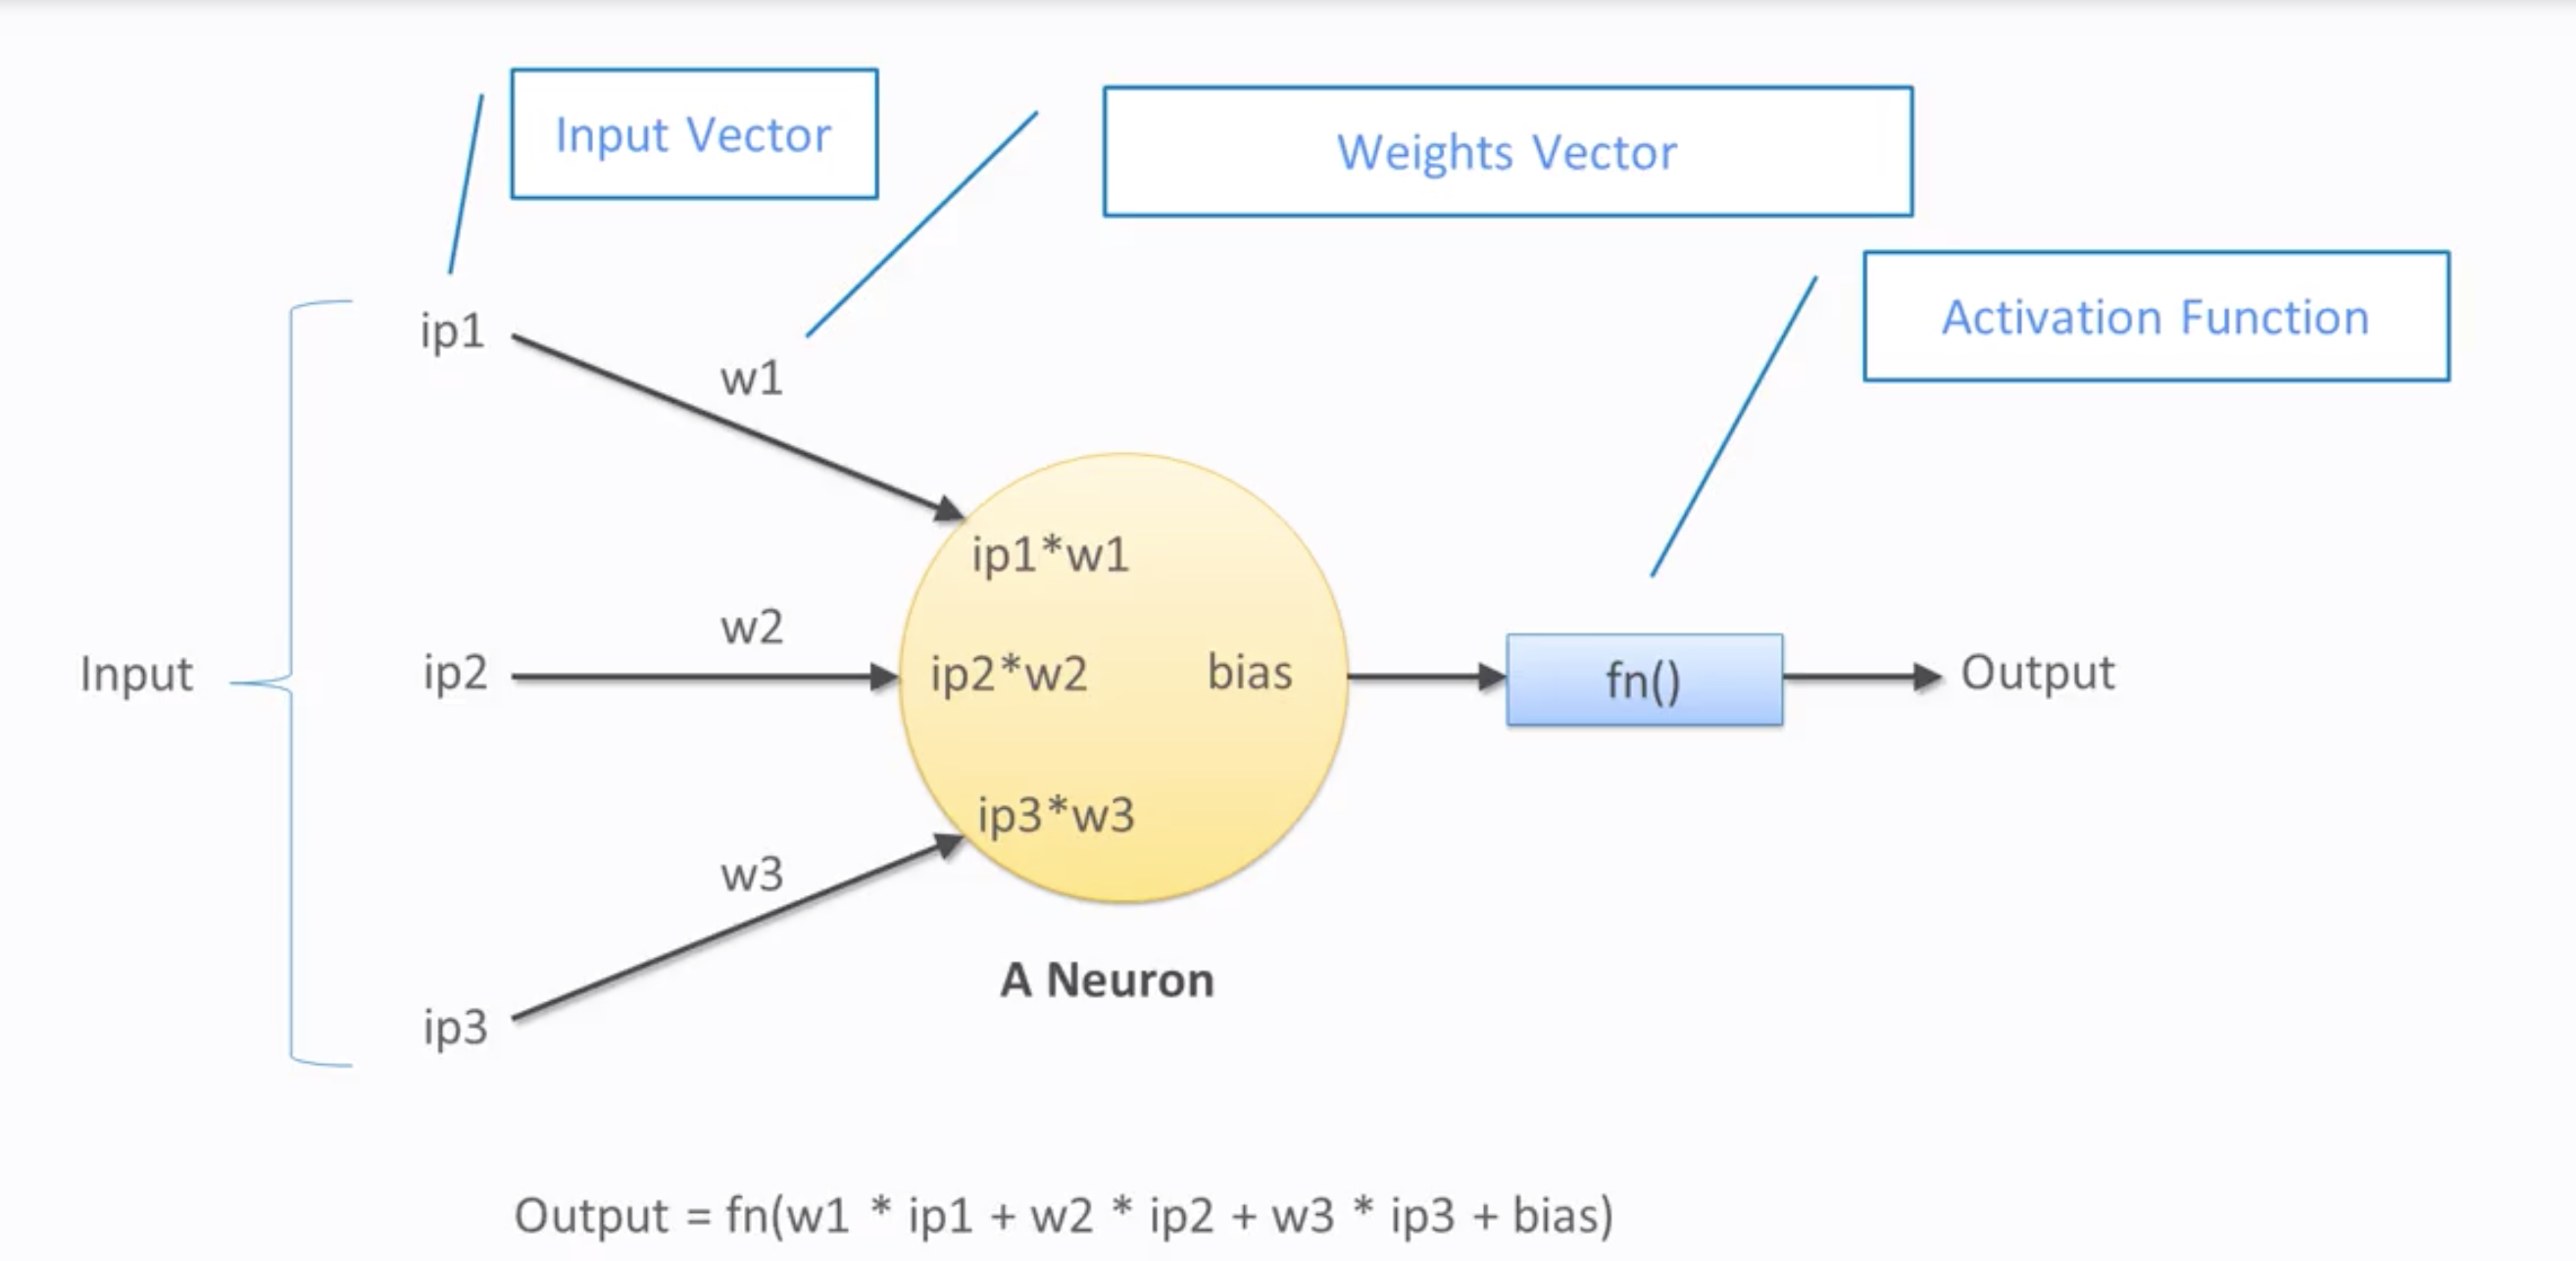

In [1]:
from IPython.display import Image
Image("neuron.png")

In the above photo you can see the architecture of a neuron. When we say we are training a Neural Net, all we are doing is adjusting the weights and the biases associated with the inputs and the neurons to achieve the desired output, close to the input (A decent loss function - Error rate).

**Activation Function** is an important component of a neural netowork. Without the activation function the result of the input to the neural net would be a linear funcion. Activatiion function decide when a neuron should fire and when the neuron should not fire based on the input and the aggregations. 

In the following image you will be able to see different actiovation functions (Linear/Nonlinear).

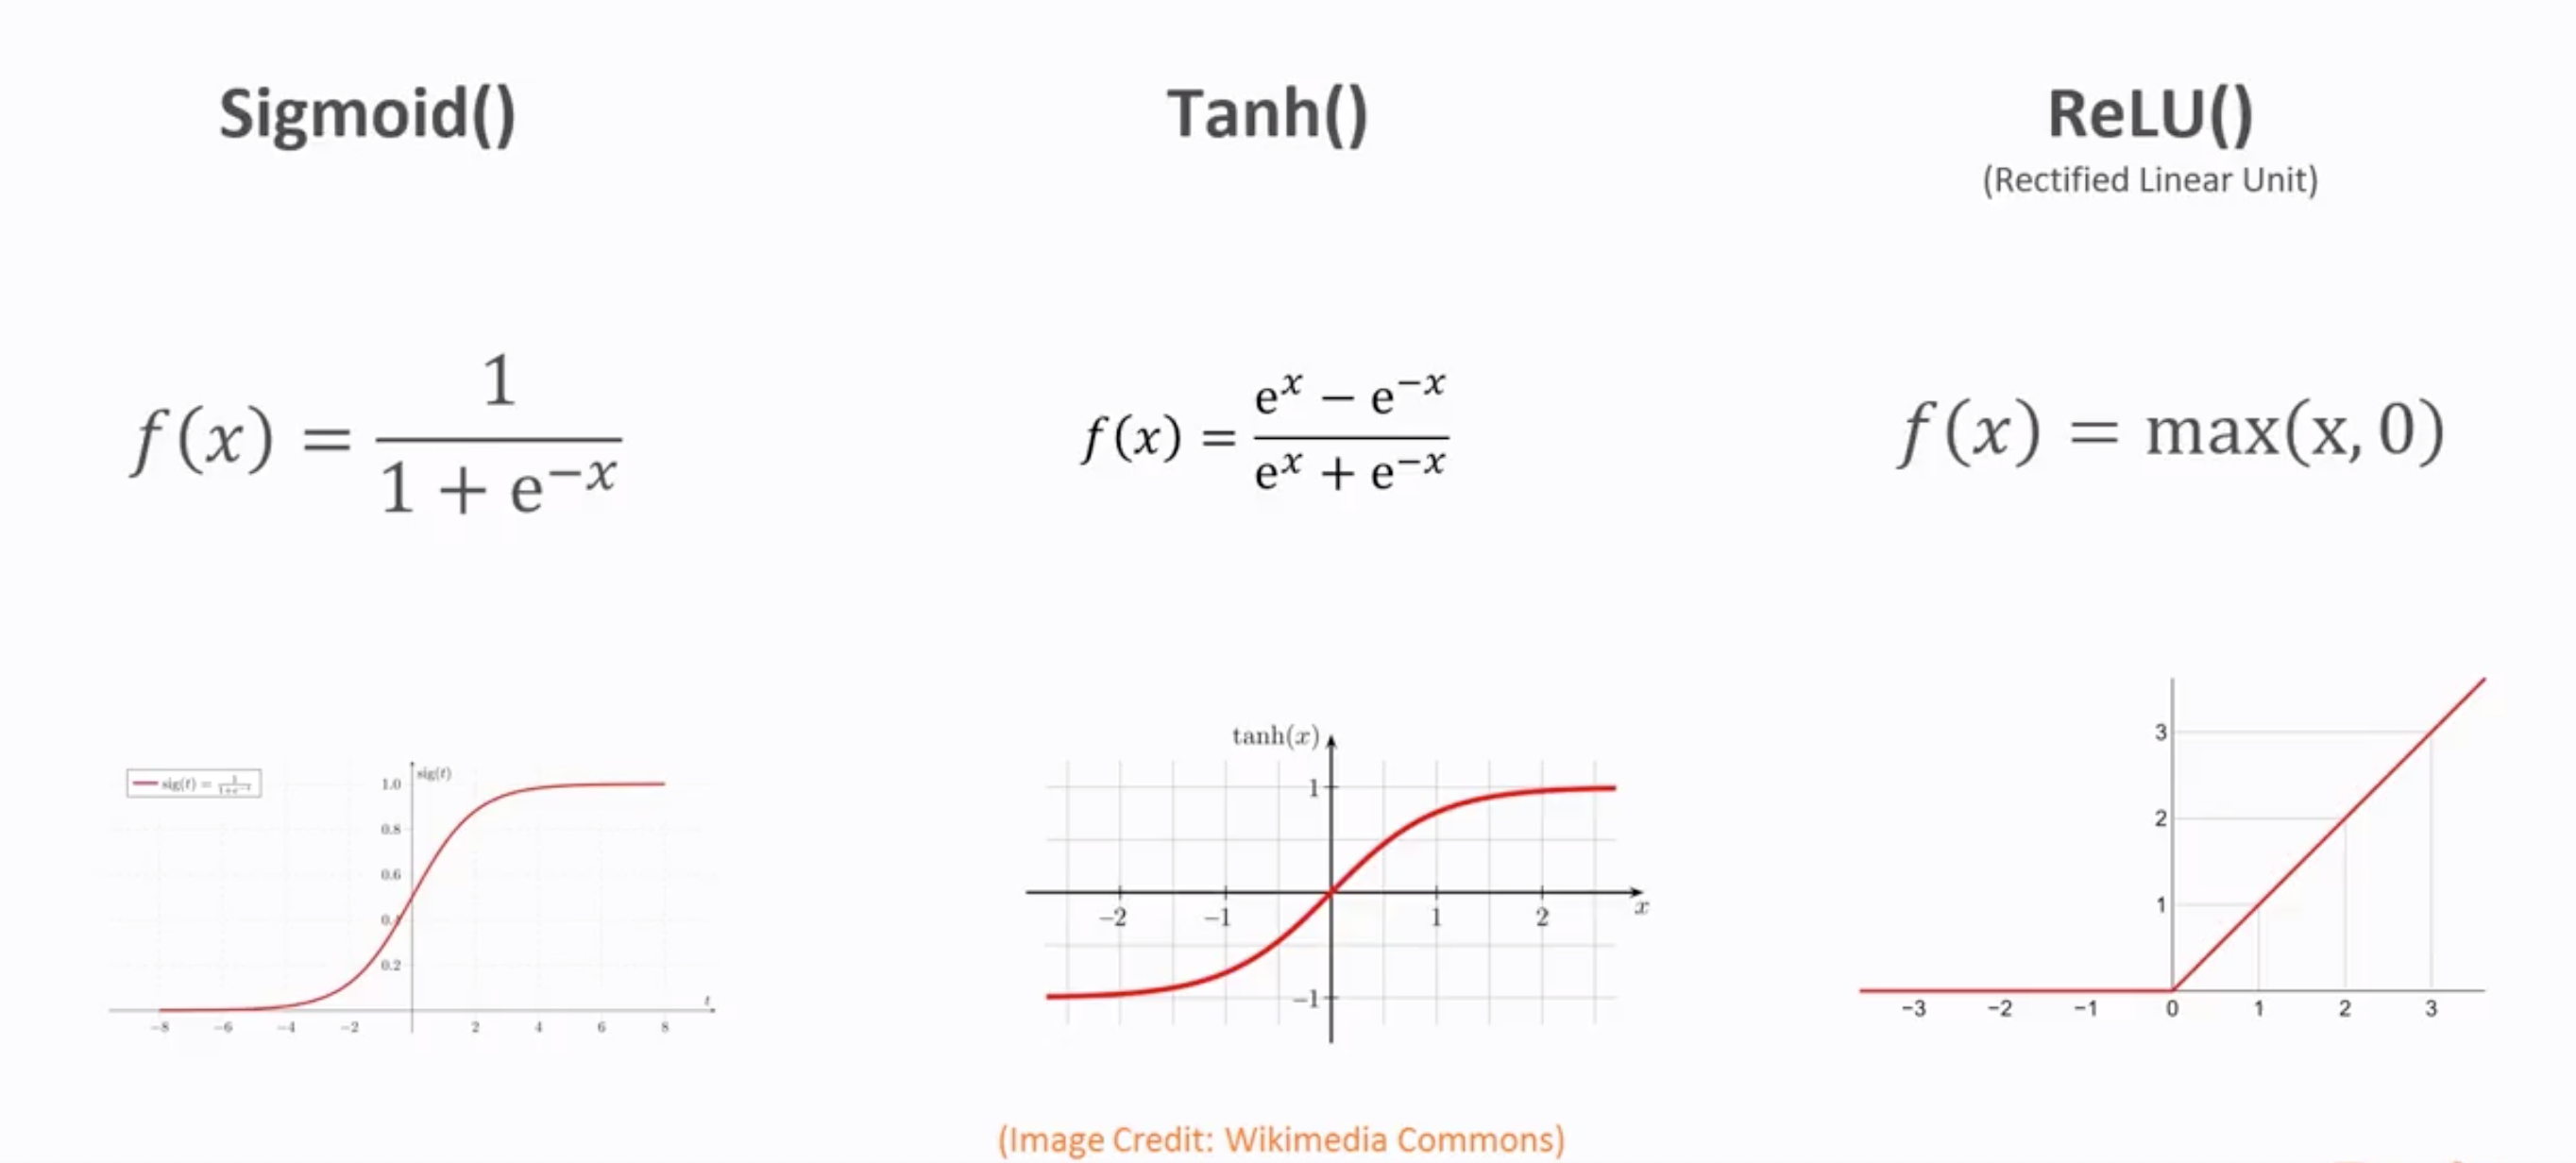

In [3]:
Image("activation_functions.png")

The architecture of a neural network is as follows:

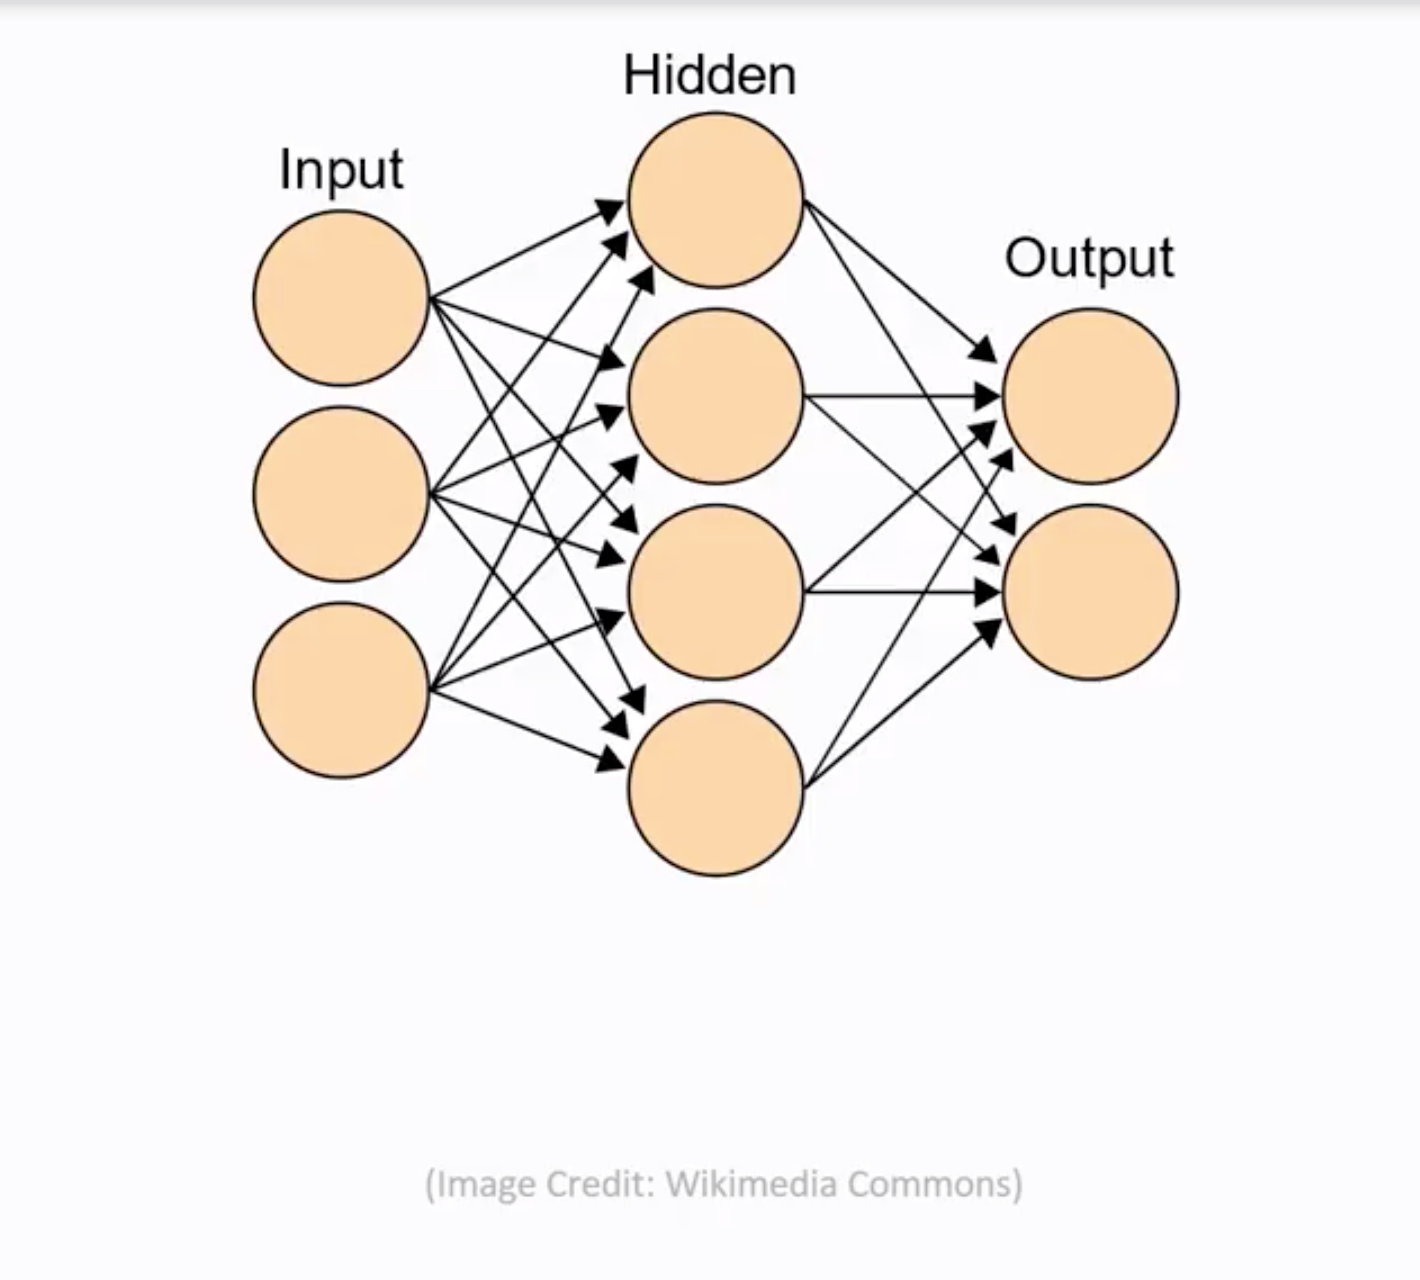

In [5]:
Image("ANNs_2.png")

The user would get the chance to work with the input and the output layers. The output result would then be passed to a *classifier* for further classifications.

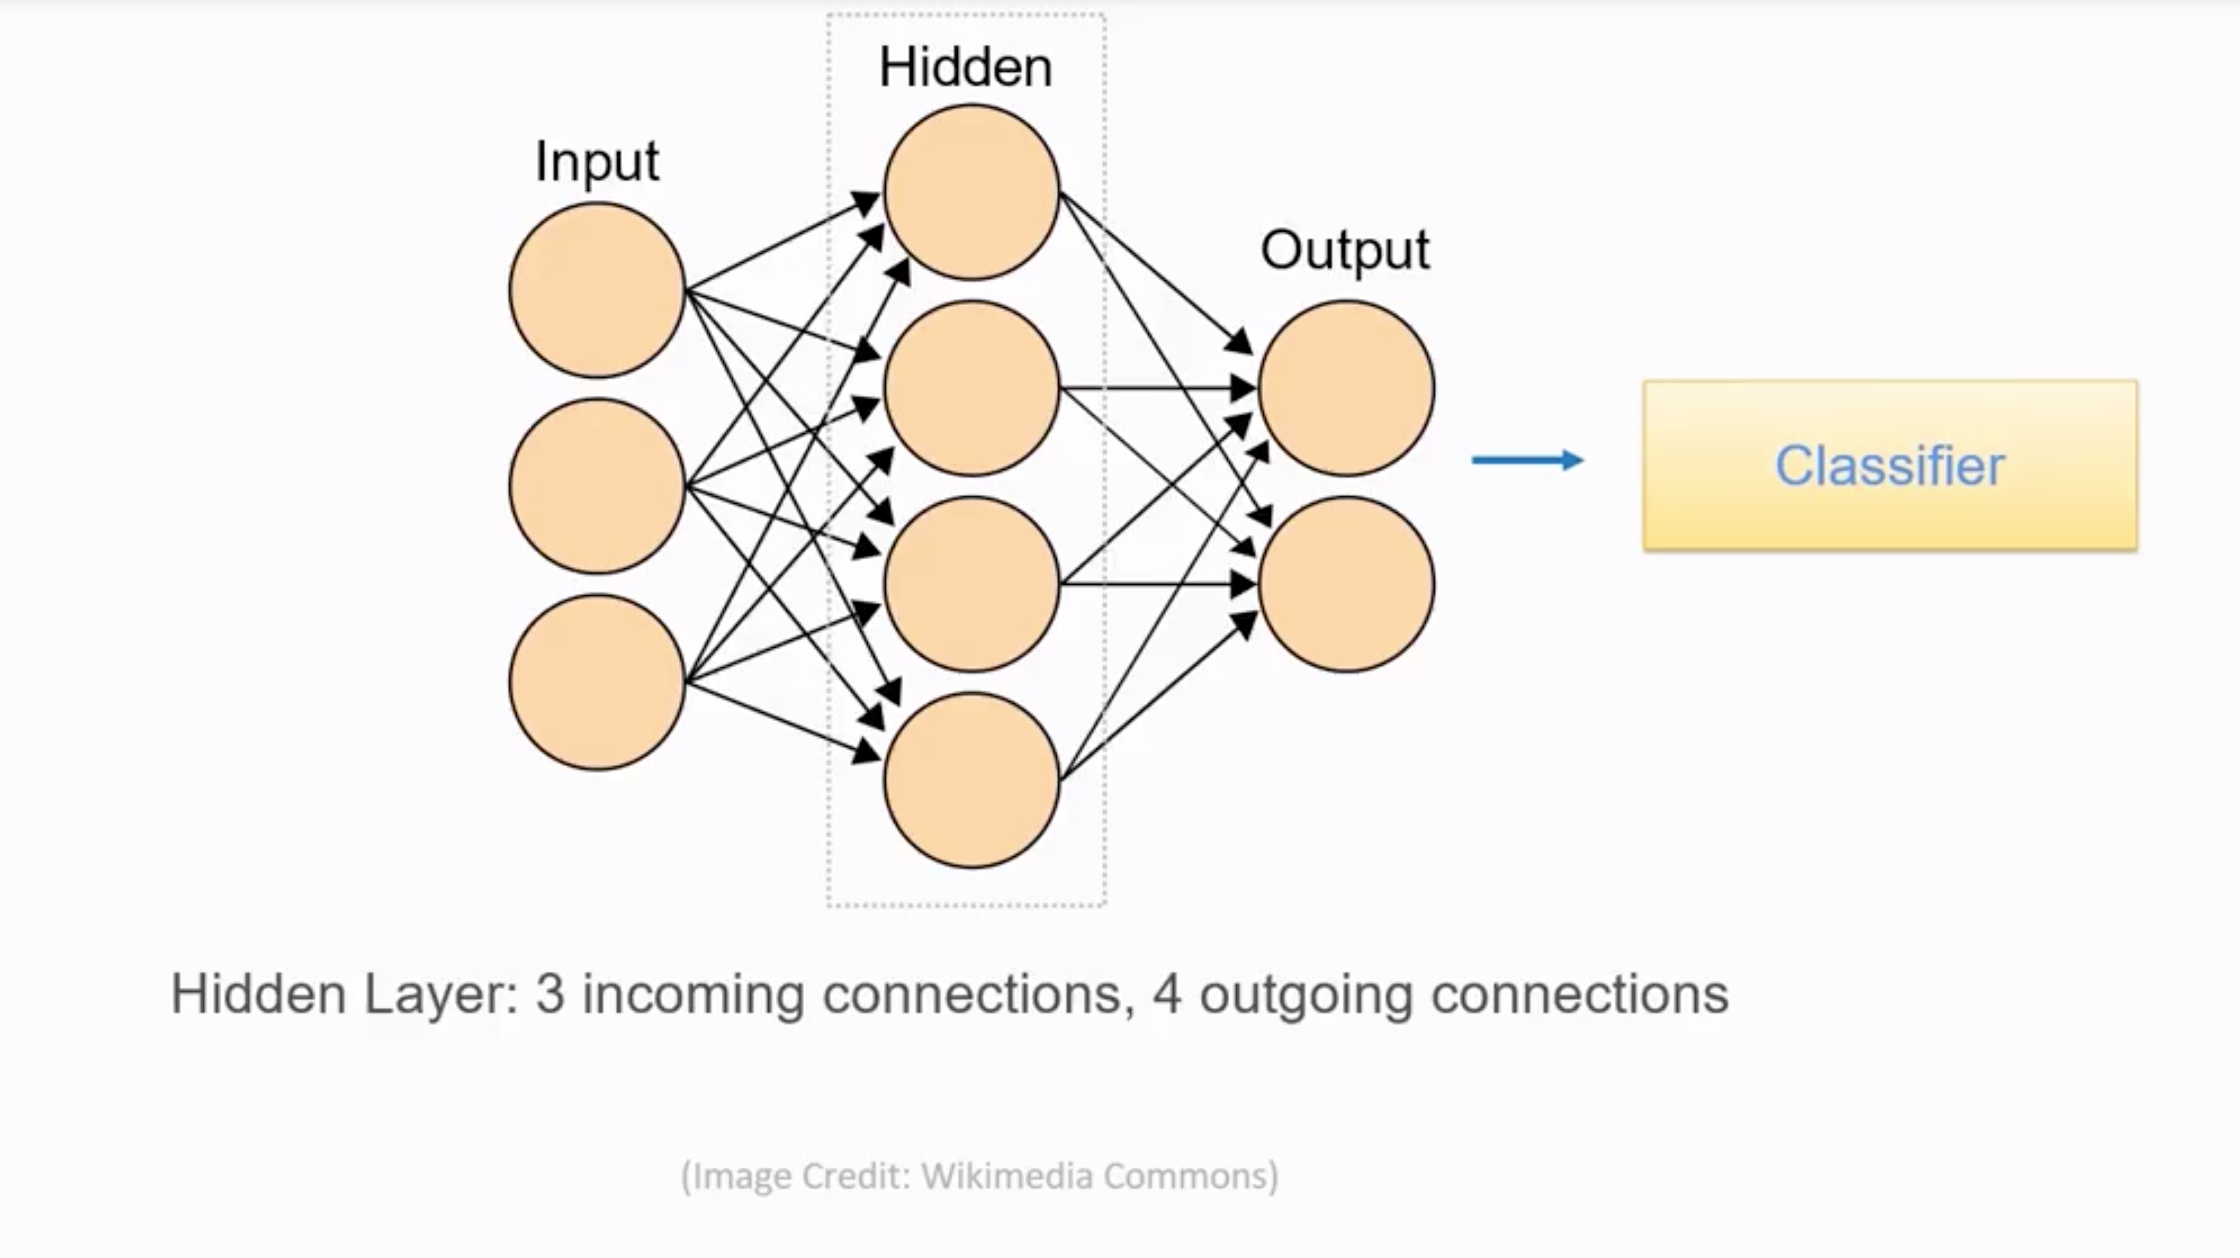

In [6]:
Image("ANNs_3.png")

### Building a Neural Net

In [1]:
import torch
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Custom Dataset
from data import iris

In [2]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


#### Create the Fully Conencted Feed Forward Neural Network

**Create the module**

In [3]:
class IrisNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        # input_size is the number of incoming edges
        # hidden1_size is the number of outcoming edges
        # This is the 1st layer
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        # This is 2nd layer
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        # This is the output layer
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [4]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


**Create the DataLoader**

In [5]:
# This is the subsample of the total sample
# Example: If in total we have 120 samples, we would have 
# 2 iterations based on the batch = 60
batch_size = 60
iris_data_file = 'data/iris.data.txt'
# Get the dataset
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# intances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloadser - for training and validation/testing
# We will be using the term validation and testing interchanbly
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle = True)
train_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle = True)



# intances in training set:  120
# instances in testing/validation set:  30


**Instantiate the network, the loss function and the optimizer**

In [6]:
# our model
net = IrisNet(4, 100, 50, 3)

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening = 0)

**Train the Model**

In [20]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.data.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.data.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.data.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 0.2126
Epoch 2/500, Iteration 1/2, Loss: 0.2121
Epoch 3/500, Iteration 1/2, Loss: 0.2117
Epoch 4/500, Iteration 1/2, Loss: 0.2112
Epoch 5/500, Iteration 1/2, Loss: 0.2107
Epoch 6/500, Iteration 1/2, Loss: 0.2102
Epoch 7/500, Iteration 1/2, Loss: 0.2098
Epoch 8/500, Iteration 1/2, Loss: 0.2093
Epoch 9/500, Iteration 1/2, Loss: 0.2088
Epoch 10/500, Iteration 1/2, Loss: 0.2084
Epoch 11/500, Iteration 1/2, Loss: 0.2079
Epoch 12/500, Iteration 1/2, Loss: 0.2074
Epoch 13/500, Iteration 1/2, Loss: 0.2070
Epoch 14/500, Iteration 1/2, Loss: 0.2065
Epoch 15/500, Iteration 1/2, Loss: 0.2060
Epoch 16/500, Iteration 1/2, Loss: 0.2056
Epoch 17/500, Iteration 1/2, Loss: 0.2051
Epoch 18/500, Iteration 1/2, Loss: 0.2047
Epoch 19/500, Iteration 1/2, Loss: 0.2042
Epoch 20/500, Iteration 1/2, Loss: 0.2038
Epoch 21/500, Iteration 1/2, Loss: 0.2033
Epoch 22/500, Iteration 1/2, Loss: 0.2029
Epoch 23/500, Iteration 1/2, Loss: 0.2024
Epoch 24/500, Iteration 1/2, Loss: 0.2020
E

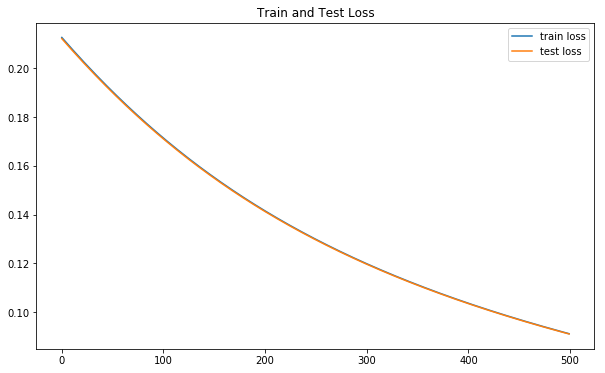

In [21]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
fig = plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

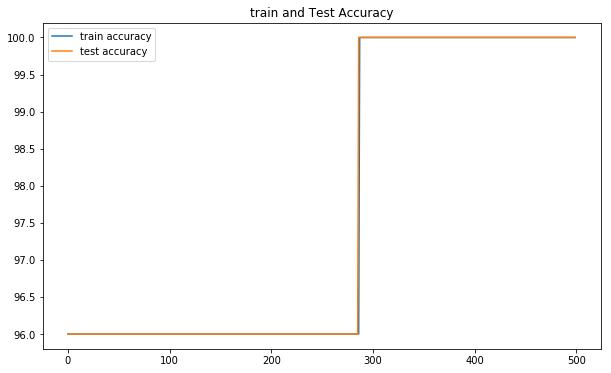

In [22]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label="train accuracy")
plt.plot(test_accuracy, label="test accuracy")
plt.title("train and Test Accuracy")
plt.legend()
plt.show()